This jupyter notebook contains the code and numerical illustrations associated with our paper *Flagfolds* https://arxiv.org/abs/2305.10583
B. Buet, X. Pennec.

This code is distributed under the 

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

Let $n \in \mathbb{N}$, $n \geq 2$. We introduce the notations:
$\mathring{\Delta}(n) = \{ \mu = (\mu_1, \ldots, \mu_n) \in (0,1)^n \: : \: \mu_1 + \ldots + \mu_n = 1 \}$ and 

$$ {\rm O}(n) = \{ U \in {\rm M}_n(\mathbb{R}) \: : \: U^T U = I_n \} \quad \text{and} \quad {\rm Sym}(n) = \{ A \in {\rm M}_n(\mathbb{R}) \: : \: A^T = A \} \quad \text{and} \quad {\rm Skew}(n) = \{ B \in {\rm M}_n(\mathbb{R}) \: : \: B^T = - B \} .$$

# Visualization with ellipsoids

We will represent $(\mu, U) \in \mathring{\Delta}(n) \times {\rm O}(n)$ by an ellipsoïd $\mathcal{Ell}(\mu,U)$ as follows. For $k \in \{1, \ldots, n\}$, we define $\lambda_k = \sum_{j=k}^n \frac{\mu_j}{j}$ and we denote by $u_k$ the $k^{th}$ column of $U$. Then, $\mathcal{Ell}(\mu,U)$ is the ellipsoïd of axes directed by $u_1, \ldots, u_n$ with semi-axis lengths $\sqrt{n \lambda_1}, \ldots, \sqrt{n \lambda_n}$.

When representing several ellipsoïds, we translate theirs centers so that they do not overlap.

<IPython.core.display.Javascript object>


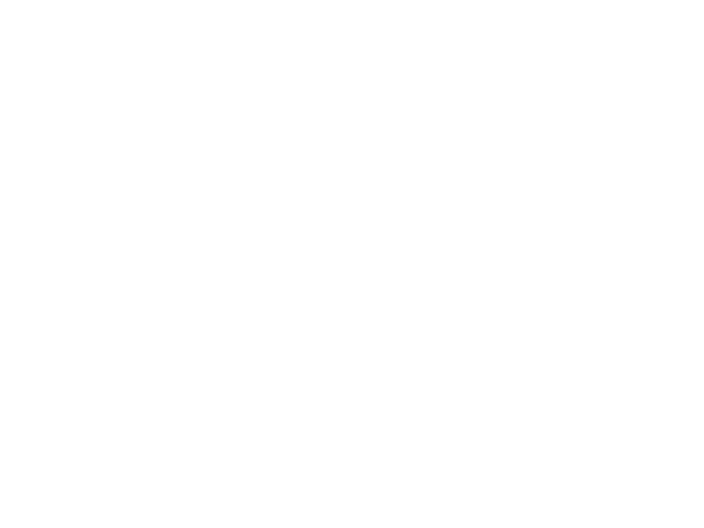

In [2]:
from mpl_toolkits import mplot3d

def ellipsoid(coefs, R):
    # coefs = (a0, a1, a2)  # Coefficients in x**2/a0 + y**2/a1 + z**2/a2 = 1 
    # coefs = (n lambda_1, ..., n lambda_n)
    rx, ry, rz = np.sqrt(coefs)
    #print(coefs)

    # Set of all spherical angles:
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    
    # Cartesian coordinates that correspond to the spherical angles:
    coord = np.zeros((3,100,100))
    coord[0] = rx * np.outer(np.cos(u), np.sin(v))
    coord[1] = ry * np.outer(np.sin(u), np.sin(v))
    coord[2] = rz * np.outer(np.ones_like(u), np.cos(v))
    #
    A = np.dot(R, np.reshape(coord,(3,100*100)))
    A = np.reshape(A,(3,100,100))
    #print(A.shape)
    
    return A[0], A[1], A[2]

x,y,z = ellipsoid(np.array([1,4,9]), np.eye(3))

%matplotlib notebook
ax = plt.axes(projection='3d')
ax.set_axis_off()
ell = ax.plot_surface(x, y, z,  rstride=4, cstride=4)
boxSize = 5
ax.set_xlim(-boxSize, boxSize) ; ax.set_ylim(-boxSize, boxSize) ; ax.set_zlim(-boxSize, boxSize)
ax.set_box_aspect((1,1,1))
plt.show()

# Numerical Scheme

*We refer to Section 5 of the Arxiv version.*

We are given $f : [0,1]^n \rightarrow [0, +\infty[$ satisfying $f(\mu) = 0$ if and only if $\mu = 0$ and we assume that $f$ is ${\rm C}^2$ in $[0,1]^n \setminus \{0\}$.

Given $1 \leq i < j \leq n$, we denote $\mu_{i \to j} = (0, \ldots, 0, \mu_i, \mu_{i+1}, \ldots,\mu_{j-1}, \mu_j, 0, \ldots, 0) \in [0,1]^n$.

We are interested in $(\mu, U) : I \subset \mathbb{R} \rightarrow \mathring{\Delta}(n) \times {\rm O}(n)$  solutions of the following differential equations:

$$
U^\prime = U B \quad \text{with } B = (b_{ij})_{ij} \in {\rm Skew(n)} \text{ and for } i<j, \, b_{ij} = \frac{1}{f(\mu_{i \to j})^2} \left( U^T U(0) C(0) U(0)^T U \right)_{ij} \quad \text{and} \quad C(0) = \left( f(\mu_{i \to j}(0))^2 b_{ij}(0) \right)_{ij} \: .
$$
and
$$
\mu_k^{\prime\prime} = \frac{1}{n}\sum_{\substack{l = 1 \\ l \neq k}}^n \sum_{1 \leq i \leq l < j \leq n} f(\mu_{i \to j}) \: \partial_l f (\mu_{i \to j}) b_{ij}^2  - \frac{n-1}{n} \sum_{1 \leq i \leq k < j \leq n} f(\mu_{i \to j}) \: \partial_k f (\mu_{i \to j}) b_{ij}^2 \quad \text{for } k \in \{1, \ldots, n\} \: .
$$

Let us discretize $[0,1]$ with $0 = t_0 < t_1 < \ldots < t_N = 1$ uniformly: for all $p$, $t_{p+1} - t_p = h = \frac{1}{N}$. We propose the following numerical scheme to compute $(\mu^{(p)}, U^{(p)})_p$ in $\mathring{\Delta}(n) \times {\rm O}(n)$:

Initial data are $(\mu^{(0)}, U^{(0)}) \in \mathring{\Delta}(n) \times {\rm O}(n)$ and $(\mu^\prime)^{(0)} \in \{ x = (x_1, \ldots, x_n) \in \mathbb{R}^n \: : \: x_1 + \ldots + x_n = 0 \}$, $B^{(0)} \in {\rm Skew(n)}$.

For $p \in \{0, \ldots, N-1\}$,

$$
\begin{align}
b_{ij}^{(p)} & = \frac{1}{f(\mu_{i \to j}^{(p)})^2} \left( (U^{(p)})^T U^{(0)} C^{(0)} (U^{(0)})^T U^{(p)} \right)_{ij} \quad \text{where} \quad C^{(0)} = \left( f(\mu_{i \to j}^{(0)})^2 b_{ij}^{(0)} \right)_{ij} \tag{$1$} \\
\mu^{(p+1)} & = \mu^{(p)} + h(\mu^\prime)^{(p)} \tag{$2$} \\
U^{(p+1)} & = U^{(p)} \exp \left(h B^{(p)} \right) \tag{$3$}\\
(\mu^\prime_k)^{(p+1)} & = (\mu^\prime_k)^{(p)} +  \frac{h}{n} \left( \sum_{l = 1}^n \sum_{1 \leq i \leq l < j \leq n} f(\mu_{i \to j}^{(p)}) \: \partial_l f (\mu_{i \to j}^{(p)}) (b_{ij}^{(p)})^2  - n \sum_{1 \leq i \leq k < j \leq n} f(\mu_{i \to j}^{(p)}) \: \partial_k f (\mu_{i \to j}^{(p)}) (b_{ij}^{(p)})^2 \right) \quad \text{for } k \in \{1, \ldots, n\} \tag{$4$} 
\end{align}
$$

We test the implementation with $f(\nu) = \frac14 |\nu|$ so that for all $k \in \{1, \ldots, n\}$ and $\nu \neq 0$, $\partial_k f(\nu) = \frac14 \frac{\nu_k}{|\nu|}$.

It is possible to change the expression of $f$, testing for instance $f(\nu) = \nu_1 + \ldots + \nu_n$.

We first define $f$ and its partial derivatives $\partial_k f$.

In [3]:
def f(nu):
    return 0.25*np.linalg.norm(nu)
    #return np.sum(nu)

def partialf(nu,k):
    return 0.25*nu[k-1]/np.linalg.norm(nu)
    #return 1.


We then define
- `troncNuItoJ` $: (\nu, i, j) \mapsto \mu_{i \to j}$, 
- `gamma` $: \nu \mapsto G \in {\rm Sym}(n)$ where $G = (G_{ij})$ is the symmetric matrix such that for $i < j$, $G_{ij} = f(\nu_{i \to j})$ and $G$ has zero coefficients on its diagonal.
- `gammaPartialf` $: \nu \mapsto Gp$ where $Gp$ is a np.ndarray of size $(n,n,n)$ and such that for $k \in \{1, \ldots , n\}$, $Gp [k , : , :]$ is a symmetric matrix with $1$ on its diagonal and
$$
Gp [k , : , :] = 
\begin{bmatrix}
1 &   &   & \\
  & \ddots & \partial_k f(\nu_{i \to j})  & \\
  &  \partial_k f(\nu_{j \to i}) & \ddots & \\
  &   &   & 1 \\
\end{bmatrix} 
$$
- `lam` $: \mu \mapsto (\lambda_1, \ldots, \lambda_n)$ defined as $\lambda_k = \sum_{j=k}^n \frac{\nu_k}{k}$.

In [4]:
def troncNuItoJ(nu,i,j):
    nuij = np.zeros_like(nu)
    nuij[(i-1):(j-1)] = nu[(i-1):(j-1)]
    return nuij

def gamma(nu):
    n = nu.size
    G = np.ones((n,n))
    for i in range(n):
        for j in range(i+1,n):
            G[i,j] = f(troncNuItoJ(nu,i+1,j+1))
            G[j,i] = f(troncNuItoJ(nu,i+1,j+1))
    return G

def gammaPartialf(nu):
    n = nu.size
    Gp = np.ones((n,n,n)) # attention : pour diviser on met 1 et pas 0 sur diag
    for k in range(n):
        for i in range(n):
            for j in range(i+1,n):
                Gp[k,i,j] = partialf(troncNuItoJ(nu,i+1,j+1), k+1)
                Gp[k,j,i] = Gp[k,i,j]
    return Gp

nu = np.array([0.1, 0.2, 0.4, 0.05, 0.15, 0.1])
print('nu = '+str(nu))
print('f(nu) = '+str(f(nu))) 
print('d_3 f(nu) = '+str(partialf(nu, 3))) 
print('nu_{2 to 5} = '+str(troncNuItoJ(nu, 2, 5)))
print('gamma(nu) ='+str(gamma(nu)))

def lam(mu):
    n = mu.size
    lamb = np.flip(np.cumsum(np.flip(mu/np.arange(1,n+1))))
    return lamb

print('lam(nu) = '+str(lam(nu)))

nu = [0.1  0.2  0.4  0.05 0.15 0.1 ]
f(nu) = 0.12374368670764584
d_3 f(nu) = 0.20203050891044214
nu_{2 to 5} = [0.   0.2  0.4  0.05 0.   0.  ]
gamma(nu) =[[1.         0.025      0.0559017  0.11456439 0.11524431 0.121192  ]
 [0.025      1.         0.05       0.1118034  0.1125     0.11858541]
 [0.0559017  0.05       1.         0.1        0.10077822 0.10752907]
 [0.11456439 0.1118034  0.1        1.         0.0125     0.03952847]
 [0.11524431 0.1125     0.10077822 0.0125     1.         0.0375    ]
 [0.121192   0.11858541 0.10752907 0.03952847 0.0375     1.        ]]
lam(nu) = [0.3925     0.2925     0.1925     0.05916667 0.04666667 0.01666667]


We carry on with the implementation of the numerical scheme allowing to compute $(\mu^{(p)}, U^{(p)}) \in \mathring{\Delta}(n) \times O(n)$.

The function `geodStartnD` takes as imput:

- a np.array `X` that contains the initial speed. More precisely, $X$ has size $(n-1) + \frac12 n(n-1)$ and the $n-1$ first entries give $(\mu^\prime)^{(0)}$ while the $\frac12 n(n-1)$ left ones are the upper coefficient of $B^{(0)}$,
- a np.array `nu0` of size $n$ that corresponds to $\mu^{(0)}$,
- a np.ndarray `U0` of size $(n,n)$ that corresponds to $U^{(0)}$.

Thanks to equations $(1)$ to $(4)$, the function `geodStartnD` computes

- a np.array `tps` of discrete times $t_p = p h$ with time step $h$ (default $h = 0.001$)
- a np.ndarray `nu` of size $(tps.size, n)$ such that `nu[p]` corresponds to $\mu^{(p)}$,
- a np.ndarray `U` of size $(tps.size, n, n)$ such that `U[p]` corresponds to $U^{(p)}$,
- a np.ndarray `length` of size $tps.size$ such that `length[p]` is an approximate arclength $\sqrt{g_{\gamma(t_p)}(\gamma^\prime(t_p), \gamma^\prime(t_p))} = \sqrt{|(\mu^\prime)^{(p)}|^2 + \sum_{1\leq i < j \leq n} f(\mu_{i \to j}^{(p)})^2 (b_{ij}^{(p)})^2}$,
- a float `energy` that is an approximate energy of the curve $\frac12 \int_0^L g_{\gamma(t)}(\gamma^\prime(t), \gamma^\prime(t)) \: dt$ (trapezoidal rule),

In [5]:
def geodStartnD(X, nu0, U0, h = 0.001):
    n = nu0.size
    #
    # time discretization
    #h = 0.001
    L = 2.
    tps = np.arange(0,L+h,h)
    N = tps.size
    #
    # Declaration of variables
    U = np.zeros((N,n,n))
    nu = np.zeros((N,n))
    lambdas = np.zeros((N,n))
    B = np.zeros((N,n,n))
    nuprime = np.zeros((N,n))
    C = np.zeros((n,n))
    #
    # Building nuprime0 and B0 from X
    nuprime0short = X[0:n-1]; b0 = X[n-1:]
    nuprime0 = np.zeros(n)
    nuprime0[:n-1] = nuprime0short
    nuprime0[n-1] = -nuprime0short.sum()
    B0 = np.zeros((n,n))
    ind = 0
    for i in range(n):
        for j in range(i+1,n):
            B0[i,j] = b0[ind]
            B0[j,i] = - B0[i,j]
            ind += 1
    #
    # t = 0:
    U[0] = U0
    nu[0] = nu0
    lambdas[0] = lam(nu0)
    B[0] = B0
    nuprime[0] =  nuprime0
    G = gamma(nu0)
    C = B0*G**2
    Ctilde = U0 @ C @ np.transpose(U0)
    length = np.zeros(N)
    energy = 0
    #
    # main iteration
    for it in range(N-1):
        # break condition in case nu takes negative values
        if  (nu[it] < 0).sum() > 0:
            print("error: nu < 0")
            break
        else:
            # numercial arglenth and energy computation
            length[it] = np.sqrt(np.linalg.norm(nuprime[it])**2 + np.sum(G**2*B[it]**2))
            energy += 0.25*(np.linalg.norm(nuprime[it])**2 + np.sum(G**2*B[it]**2))*h
            # Eq (2) and (3)
            U[it+1] = np.dot(U[it], linalg.expm(h*B[it]))
            nu[it+1] = nu[it] + h*nuprime[it]
            # Eq (4)
            Gp = gammaPartialf(nu[it])
            M = np.sum(Gp, axis=0)
            for k in range(n):
                Mk = (M - n*Gp[k])*G*B[it]**2
                nuprime[it+1,k] = nuprime[it,k] + h/n*np.sum(Mk)
            # Eq (1) for next iteration
            C = np.transpose(U[it+1]) @ Ctilde @ U[it+1]
            G = gamma(nu[it+1])
            B[it+1] = C/G**2
            #
            lambdas[it+1] = lam(nu[it+1])
            #
            energy += 0.25*(np.linalg.norm(nuprime[it])**2 + np.sum(G**2*B[it]**2))*h
            #
            # break condition if the numerical arclength is too far from constant   
            #BREAK CONDITION IMPLEMENTED IN THE NUMERICAL EXPERIMENT OF THE PAPER
            if it>1 and np.abs(length[it]-length[it-1])/length[it]>0.01:
                break
            #BETTER BREAK CONDITION
            #if it>6 and np.sum(np.abs(length[it-5:it]-length[it-6:it-1]))/h > 10.:
                #break
            
            
    return tps[:it], nu[:it], U[:it], lambdas[:it], nuprime[:it], length[:it], energy, h


The following function `traceGeod` allows to visualize a path $\gamma = (\mu, \nu)$, for instance obtained via the numerical computation above, in case $n = 3$.
See examples below, corresponding to the numerical experiments displayed in the paper.

In [6]:
def traceGeod(tps,nu,U,lambdas, nuprime,l, save = False, filename = '0'):
    n = nu[0].size
    #
    print('nu0 = '+str(np.round(nu[0],3)))
    print('nu1 = '+str(np.round(nu[-1],3)))
    print('U0 = '+str(np.round(U[0],3)))
    print('U1 = '+str(np.round(U[-1],3)))
    #
    itMax = nu.shape[0]
    print('itMax = '+str(itMax))
    print('temps max = '+str(tps[-1]))
    per = int((itMax-1)/9)
    #
    %matplotlib inline
    plt.figure(1, figsize=(21,7))
    plt.subplot(1,3,1)
    labels1 = []
    for i in range(3):
        labels1 = labels1 + [r'$\mu$'+str(i+1)+r'$ :$'+str(round(nu[0,i],3))+r'$\rightarrow $'+str(round(nu[-1,i],3))]
        plt.plot(tps,nu[:,i])
    plt.plot(tps,np.sum(nu, axis=1))
    labels1 = labels1+[r'$\sum_i \mu_i = 1$']
    plt.legend(labels1)
    plt.title(r'$\mu_i$ en fonction du temps')
    #
    plt.subplot(1,3,2)
    labels2 = []
    for i in range(3):
        labels2 = labels2 + [r'$\lambda$'+str(i+1)+r'$ :$'+str(round(lambdas[0,i],3))+r'$\rightarrow $'+str(round(lambdas[-1,i],3))]
        plt.plot(tps,lambdas[:,i])
    plt.legend(labels2)
    plt.title(r'$\lambda_i$ en fonction du temps')
    # curve in the simplex of vertices (-1,0), (1,0) et (0,np.sqrt(3))
    plt.subplot(1,3,3)
    labels3 = []
    for i in range(3):
        labels3 = labels3 + [r'$\mu^\prime$'+str(i+1)+r'$ :$'+str(round(nuprime[0,i],3))+r'$\rightarrow $'+str(round(nuprime[-1,i],3))]
        plt.plot(tps,nuprime[:,i])
    plt.plot(tps,np.sum(nuprime, axis=1))
    labels3 = labels3+[r'$\sum_i \mu_i^\prime = 0$']
    plt.legend(labels3)
    plt.title(r'$\mu_i^\prime$ en fonction du temps')
    #
    fig = plt.figure(2,figsize=(21,7),frameon=False)
    plt.title(r'ellipsoid whose axes are the columns of $U = (U_1, U_2, U_3)$ associated with semi-axes length $(\sqrt{\lambda_1}, \sqrt{\lambda_2}, \sqrt{\lambda_3} )$ plotted at different times')
    plt.axis('off')
    ax1, ax2, ax3 = fig.subplots(nrows=1, ncols=3)
    for i in range(10):
        x,y,z = ellipsoid(n*lam(nu[per*i]),U[per*i])
        ax1.plot(i+x.reshape(100*100),i+y.reshape(100*100))
        ax1.set_xlabel('frame (x,y)')
        ax2.plot(i+y.reshape(100*100),i+z.reshape(100*100))
        ax2.set_xlabel('frame (y,z)')
        ax3.plot(i+x.reshape(100*100),i+z.reshape(100*100))
        ax3.set_xlabel('frame (x,z)')
    plt.show()
    #
    theta = np.zeros((itMax,2))
    fig = plt.figure(3, figsize=(21,7))
    plt.subplot(1,3,1)
    plt.title(r'$i^{th}$ principal angle $\theta_i$ between $i$--dimensional subspaces ${\rm span} (U_1, \ldots, U_i)$ at times $0$ and $t$')
    for i in range(1,3):
        for k in range(itMax):
            #A = np.dot(U[0,:,:i].T, U[k,:,:i])
            s = np.linalg.svd(np.dot(U[0,:,:i].T, U[k,:,:i]))[1]
            theta[k,i-1] = np.arccos(min(1.,s[i-1]))
    plt.plot(tps, theta)
    #plt.plot(tps, np.arctan2(U[:,1,0],U[:,0,0]))
    plt.legend([r'$\theta_1$', r'$\theta_2$'])
    #
    plt.subplot(1,3,2)
    plt.plot(-nu[:,0] + nu[:,1], np.sqrt(3)*nu[:,2], label = r'$t \mapsto \mu(t) $')
    plt.plot([-1,1,0,-1],[0,0,np.sqrt(3),0])
    plt.title(r'Image of the curve of $t \mapsto \mu(t)$ in the simplex')
    plt.legend()
    plt.ylim(-0.2,2)
    #
    plt.subplot(1,3,3)
    plt.plot(tps[1:], l[1:])
    plt.ylim(0,3)
    plt.title(r'numerical arclength $t \mapsto \sqrt{g_{\gamma(t)}(\gamma^\prime(t), \gamma^\prime(t))}$')
    plt.show()
    #
    if save:
        plt.rcParams.update({'font.size': 20, 'lines.linewidth' : 4})
        plt.figure(10, figsize=(7,7))
        for i in range(3):
            plt.plot(tps,nu[:,i])
        plt.plot(tps,np.sum(nu, axis=1))
        plt.legend(labels1, fontsize=18)
        plt.savefig('flagfoldsFigures/nu'+filename+'.pdf')
        plt.figure(11, figsize=(7,7))
        for i in range(3):
            plt.plot(tps,lambdas[:,i])
        plt.legend(labels2, fontsize=18)
        plt.savefig('flagfoldsFigures/lambda'+filename+'.pdf')
        plt.figure(12, figsize=(7,7))
        for i in range(3):
            plt.plot(tps,nuprime[:,i])
        plt.plot(tps,np.sum(nuprime, axis=1))
        plt.legend(labels3, fontsize=18, loc = 'best')
        plt.savefig('flagfoldsFigures/nuprime'+filename+'.pdf')
        plt.figure(13, figsize=(7,7))
        for i in range(10):
            x,y,z = ellipsoid(n*lam(nu[per*i]),U[per*i])
            plt.plot(i+x.reshape(100*100),i+y.reshape(100*100))
            #plt.xlabel('frame (x,y)')
        plt.savefig('flagfoldsFigures/ellipsoidxy'+filename+'.pdf')
        plt.figure(14, figsize=(7,7))
        for i in range(10):
            x,y,z = ellipsoid(n*lam(nu[per*i]),U[per*i])
            plt.plot(i+y.reshape(100*100),i+z.reshape(100*100))
            #plt.xlabel('frame (y,z)')
        plt.savefig('flagfoldsFigures/ellipsoidyz'+filename+'.pdf')
        plt.figure(15, figsize=(7,7))
        for i in range(10):
            x,y,z = ellipsoid(n*lam(nu[per*i]),U[per*i])
            plt.plot(i+x.reshape(100*100),i+z.reshape(100*100))
            #plt.xlabel('frame (x,z)')
        plt.savefig('flagfoldsFigures/ellipsoidxz'+filename+'.pdf')
        plt.figure(16, figsize=(7,7))
        for i in range(1,3):
            for k in range(itMax):
            #A = np.dot(U[0,:,:i].T, U[k,:,:i])
                s = np.linalg.svd(np.dot(U[0,:,:i].T, U[k,:,:i]))[1]
                theta[k,i-1] = np.arccos(min(1.,s[i-1]))
        plt.plot(tps, theta)
        plt.legend([r'$\theta_1$', r'$\theta_2$'], fontsize=18)
        plt.savefig('flagfoldsFigures/theta'+filename+'.pdf')
        plt.figure(17, figsize=(7,7))
        plt.plot(-nu[:,0] + nu[:,1], np.sqrt(3)*nu[:,2], label = r'$t \mapsto \nu(t) $')
        plt.plot([-1,1,0,-1],[0,0,np.sqrt(3),0])
        plt.ylim(-0.2,2)
        plt.savefig('flagfoldsFigures/simplex'+filename+'.pdf')
        plt.figure(18, figsize=(7,7))
        plt.plot(tps[1:], l[1:])
        plt.ylim(0,3)
        plt.savefig('flagfoldsFigures/arclength'+filename+'.pdf')
        #
        #plt.rcParams.update({'font.size': 10})
        plt.rcdefaults()
    #
    #    
    %matplotlib notebook
    plt.figure(4, figsize=(9,9))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    boxSize = 10
    ax.set_xlim(-1, boxSize) ; ax.set_ylim(-1, boxSize) ; ax.set_zlim(-1, boxSize)
    ax.set_box_aspect((1,1,1))
    #
    for i in range(10):
        #print('temps '+str(round(tps[per*i],3))+' : U = '+str(np.round(U[per*i],3))+' and  nu = '+str(np.round(nu[per*i],3)))
        x,y,z = ellipsoid(n*lam(nu[per*i]),U[per*i])
        ax.plot_surface(i+x, i+y, i+z,  rstride=4, cstride=4)


nu0 = [0.98 0.01 0.01]
nu1 = [0.028 0.95  0.023]
U0 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U1 = [[ 0.039  0.738  0.674]
 [-0.997  0.072 -0.021]
 [-0.064 -0.671  0.739]]
itMax = 941
temps max = 0.9400000000000001


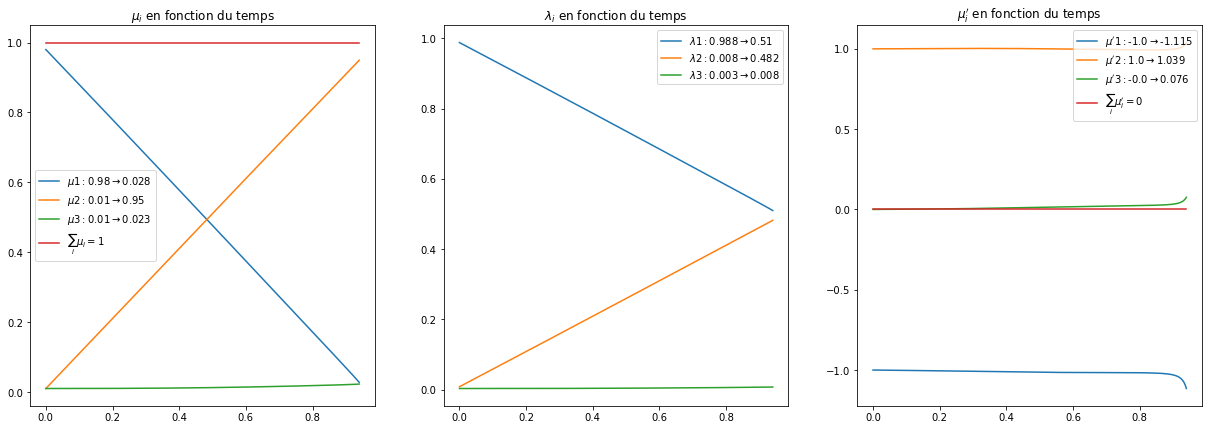

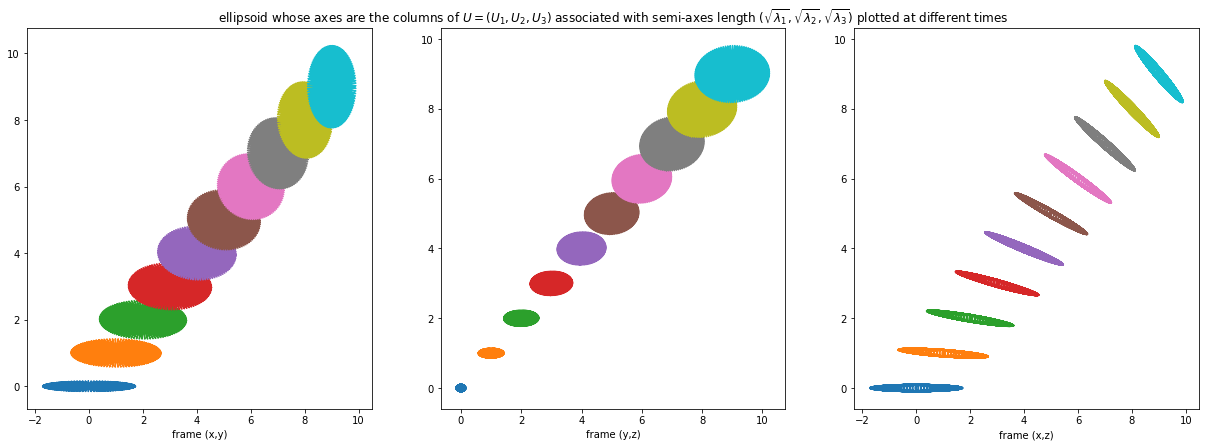

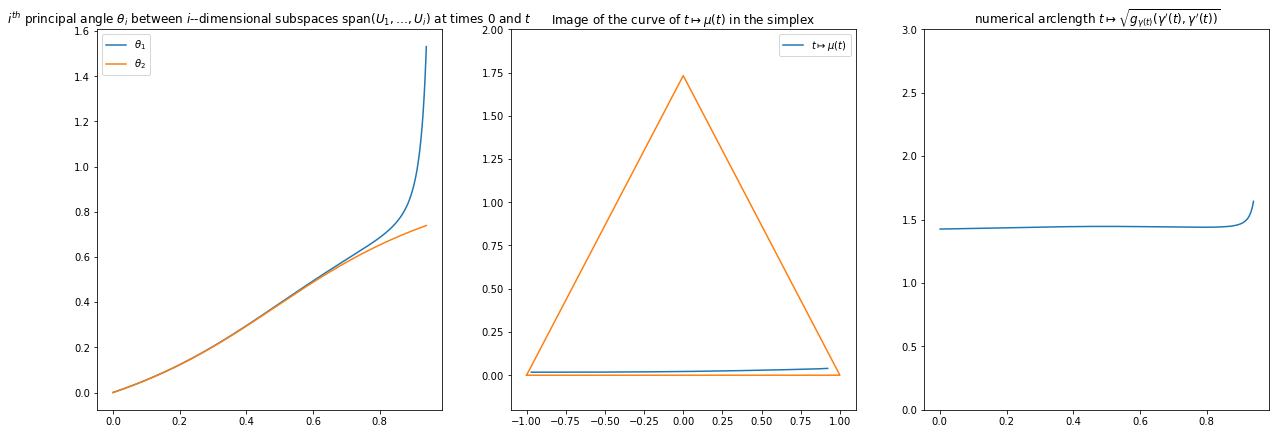

<IPython.core.display.Javascript object>


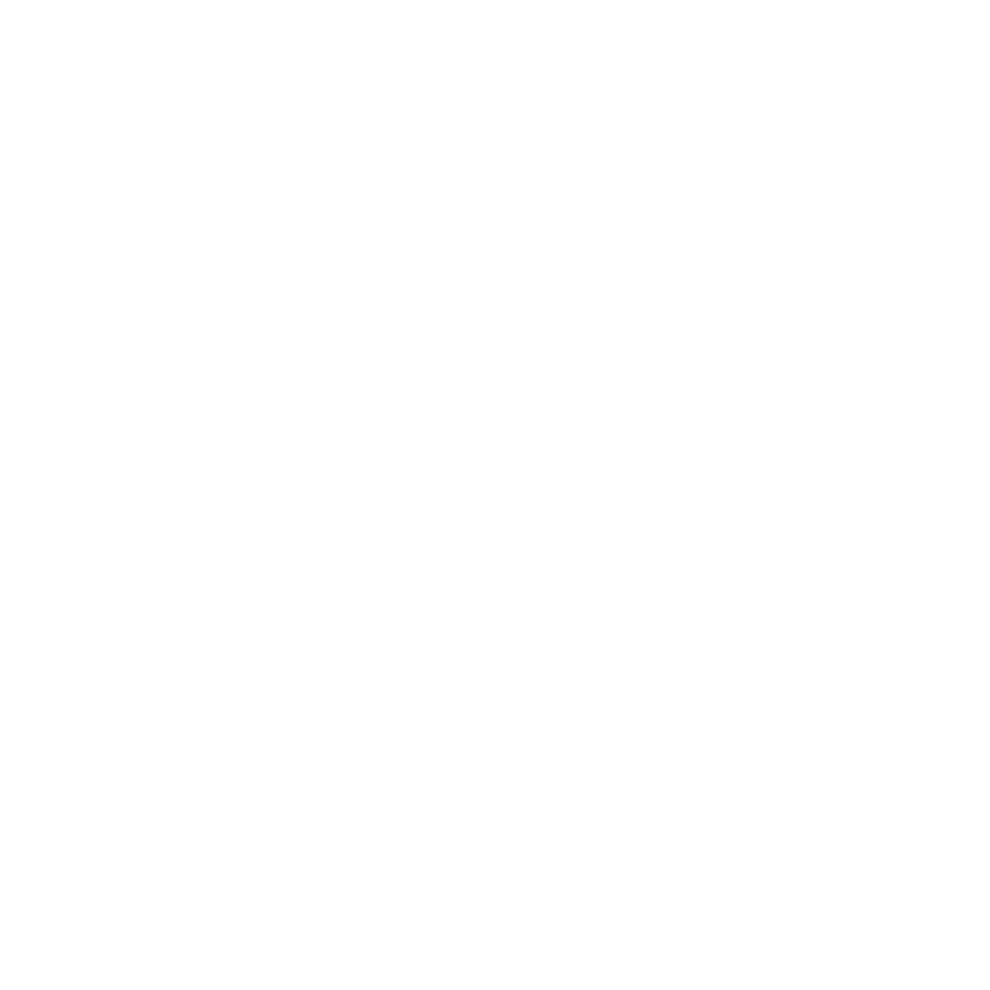

In [7]:
##Example 1: line to plane
X = np.array([-1,  1, 0.05, 0.5, 0.]); nu0 = np.array([0.98, 0.01, 0.01]); U0 = np.eye(3)
tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
traceGeod(tps,nu,U, lambdas, nuprime, l, False,'LineToPlane')


error: nu < 0
nu0 = [0.333 0.333 0.333]
nu1 = [1. 0. 0.]
U0 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U1 = [[ 0.994  0.111  0.   ]
 [-0.111  0.994  0.   ]
 [ 0.     0.     1.   ]]
itMax = 668
temps max = 0.667


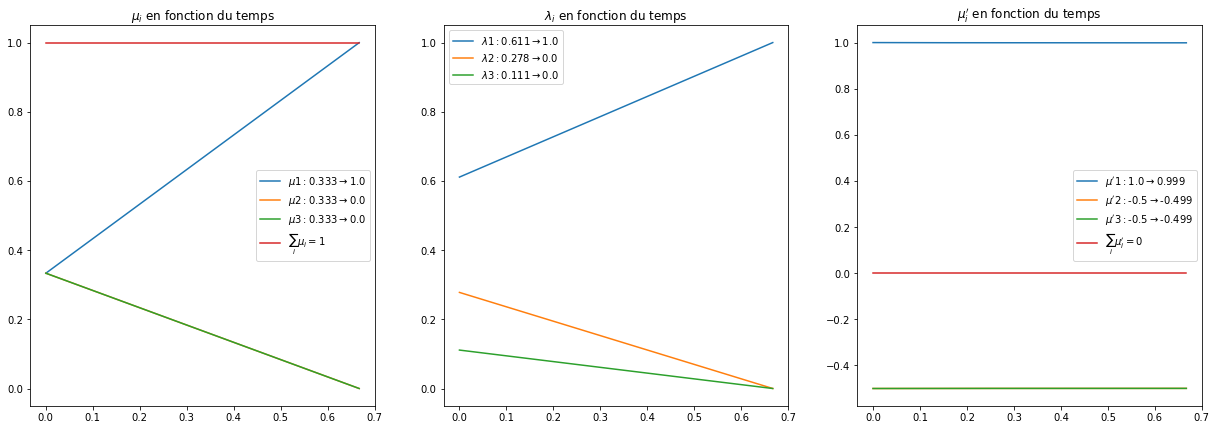

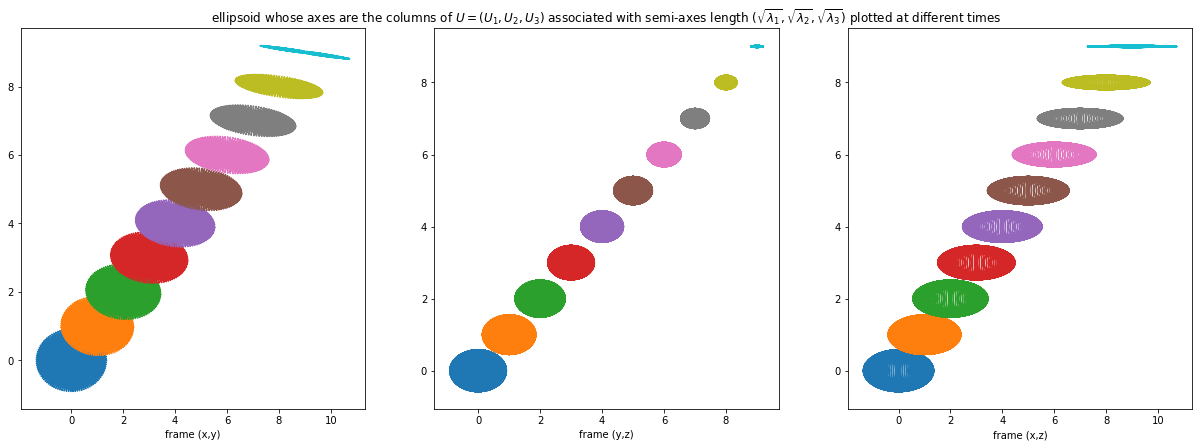

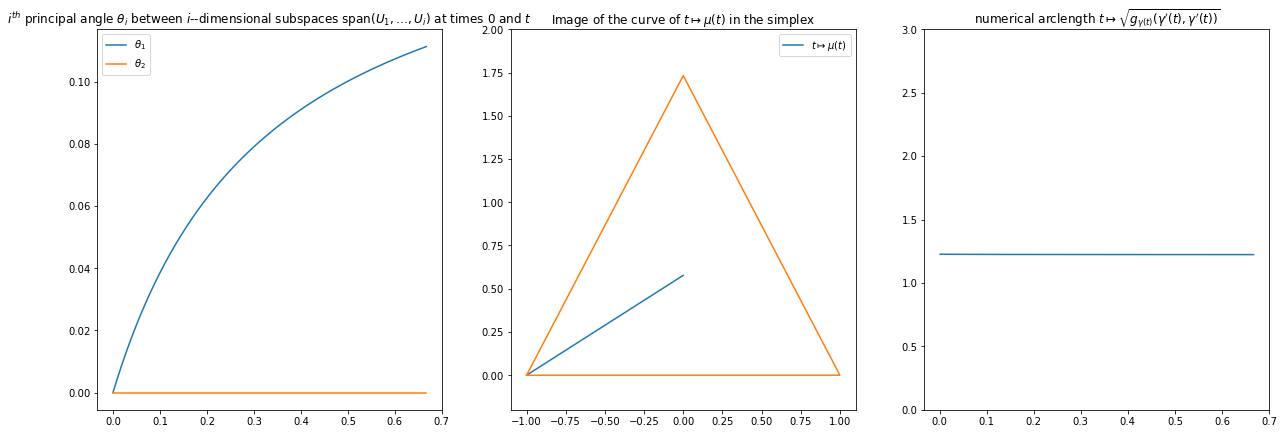

<IPython.core.display.Javascript object>


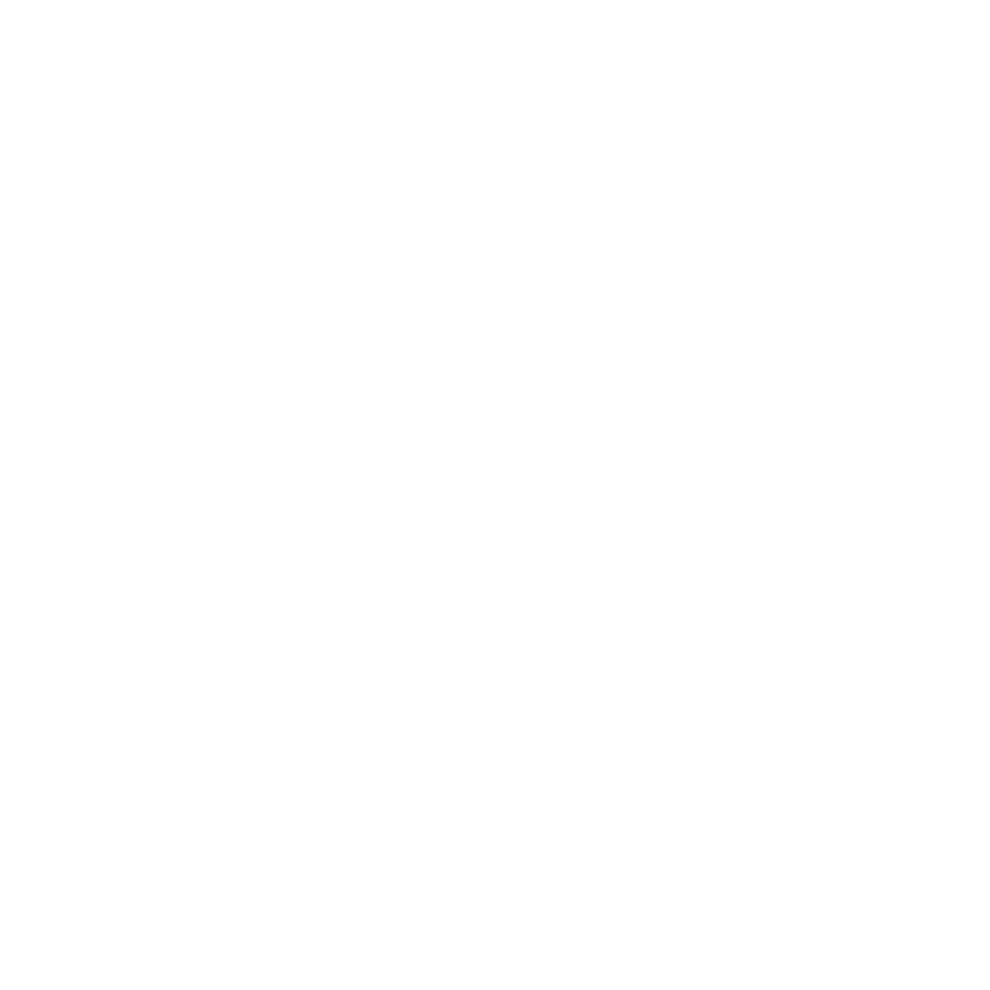

In [8]:
##Example 2: complete flag to line
X = np.array([1,  -0.5, 0.5, 0., 0.]); nu0 = np.array([1/3, 1/3, 1/3]); U0 = np.eye(3)
tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
traceGeod(tps,nu,U, lambdas, nuprime, l, False,'CompleteFlagToLine')


nu0 = [0.499 0.499 0.002]
nu1 = [0.643 0.008 0.349]
U0 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U1 = [[ 0.921  0.094  0.378]
 [-0.372  0.5    0.782]
 [-0.115 -0.861  0.496]]
itMax = 987
temps max = 0.986


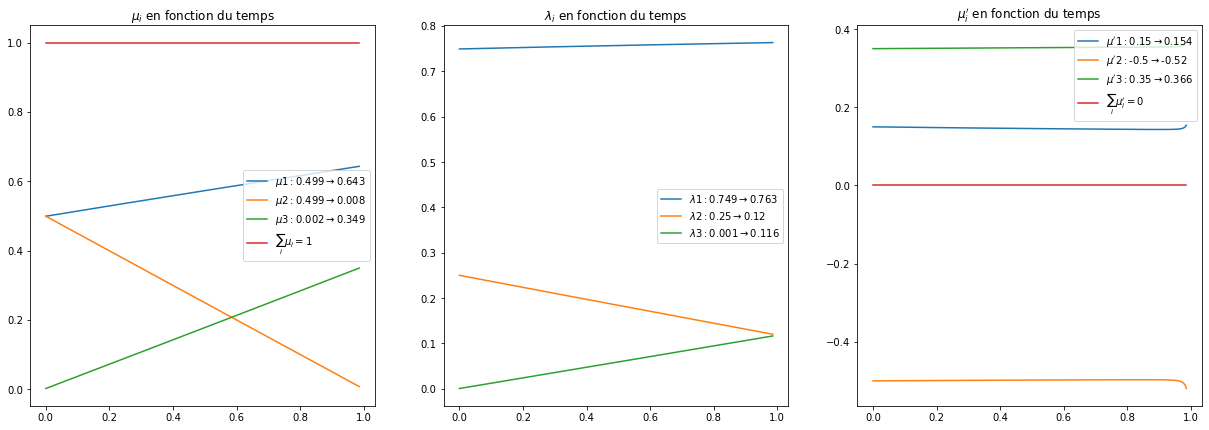

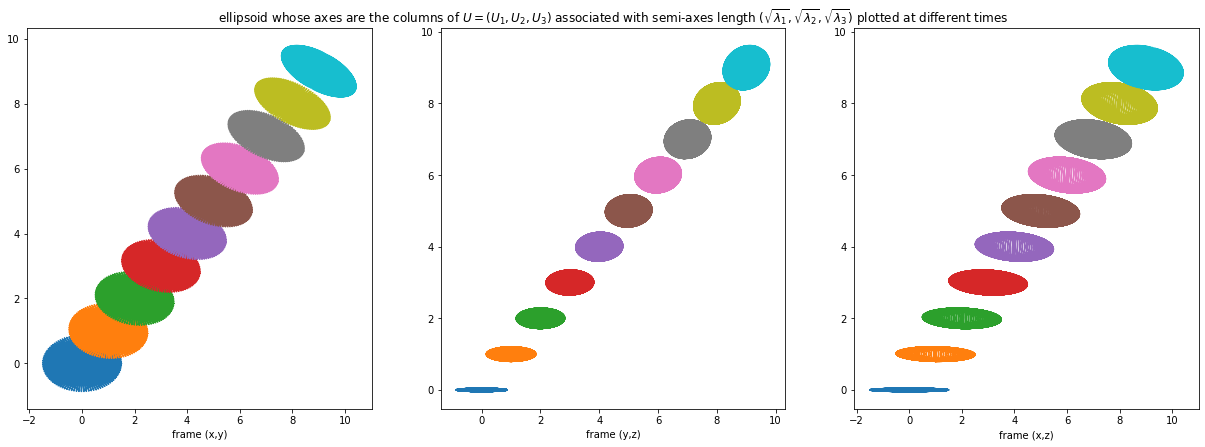

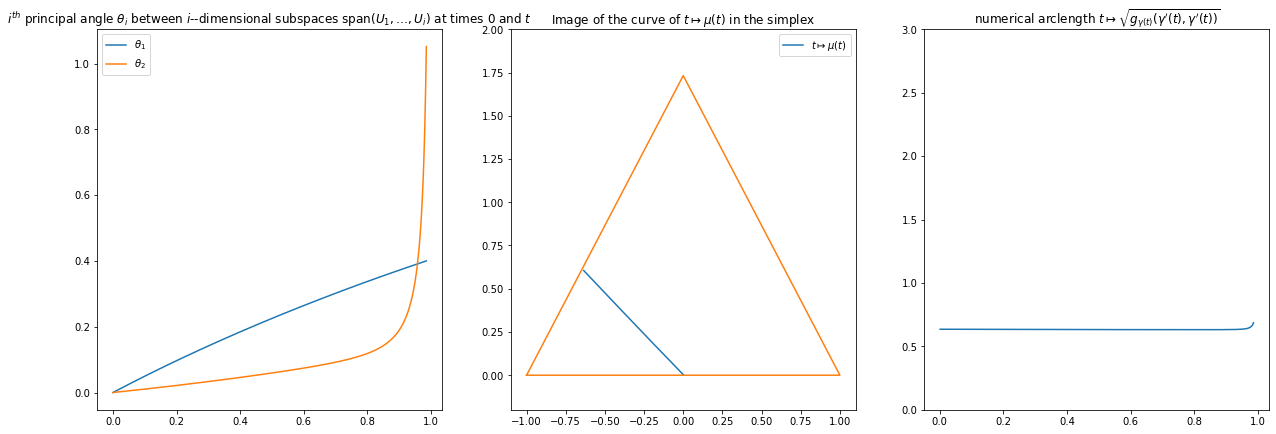

<IPython.core.display.Javascript object>


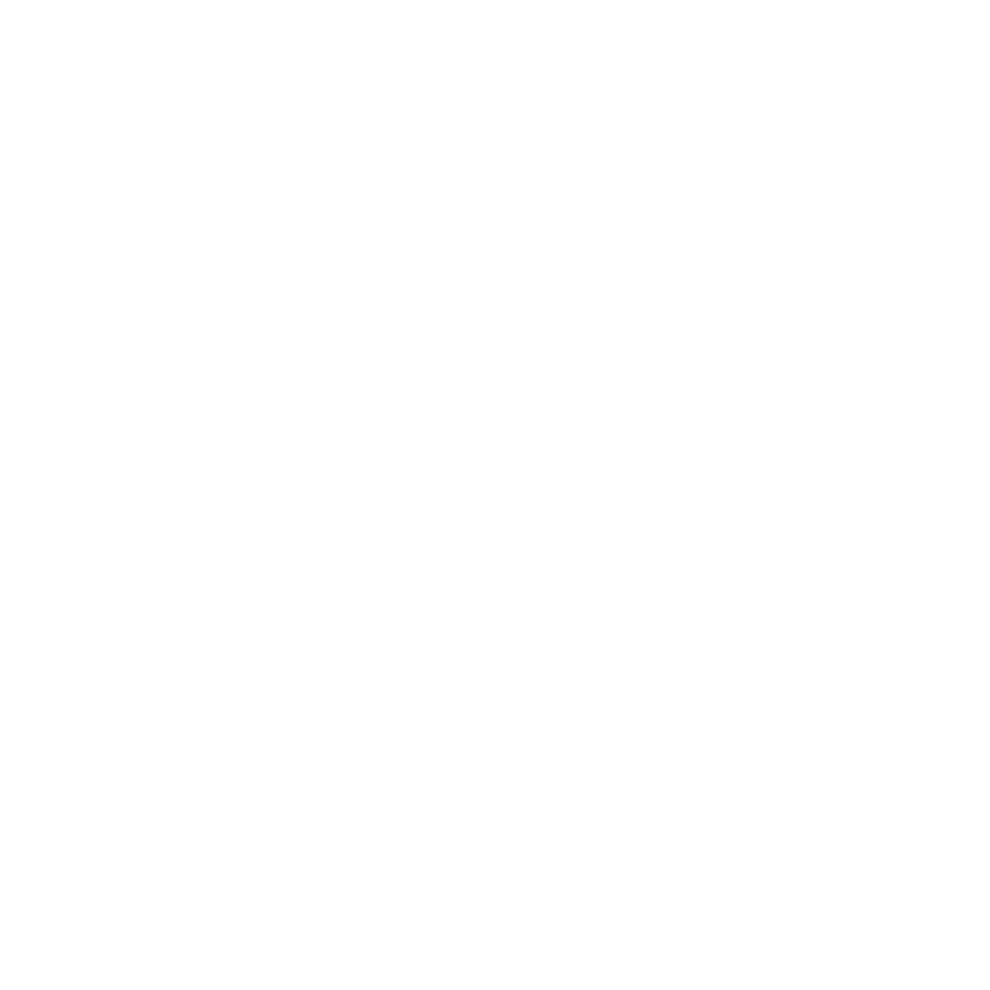

In [9]:
##Example 3: plane-line to line-R^3
X = np.array([0.15,  -0.5, 0.5, 0.1, 0.]); nu0 = np.array([0.499, 0.499, 0.002]); U0 = np.eye(3)
tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
traceGeod(tps,nu,U, lambdas, nuprime, l, False,'PlaneLineToR3')


error: nu < 0
nu0 = [0.98 0.01 0.01]
nu1 = [0.001 0.01  0.989]
U0 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U1 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
itMax = 980
temps max = 0.979


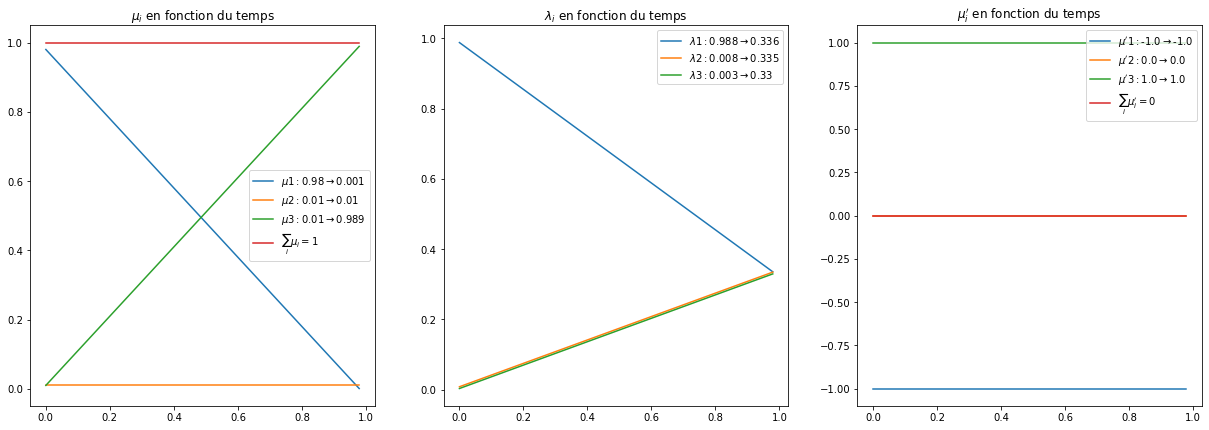

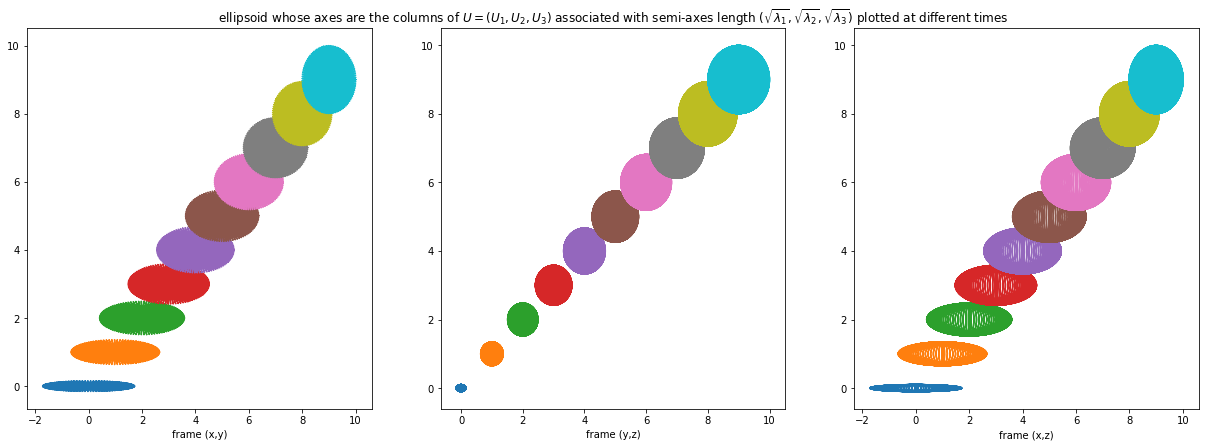

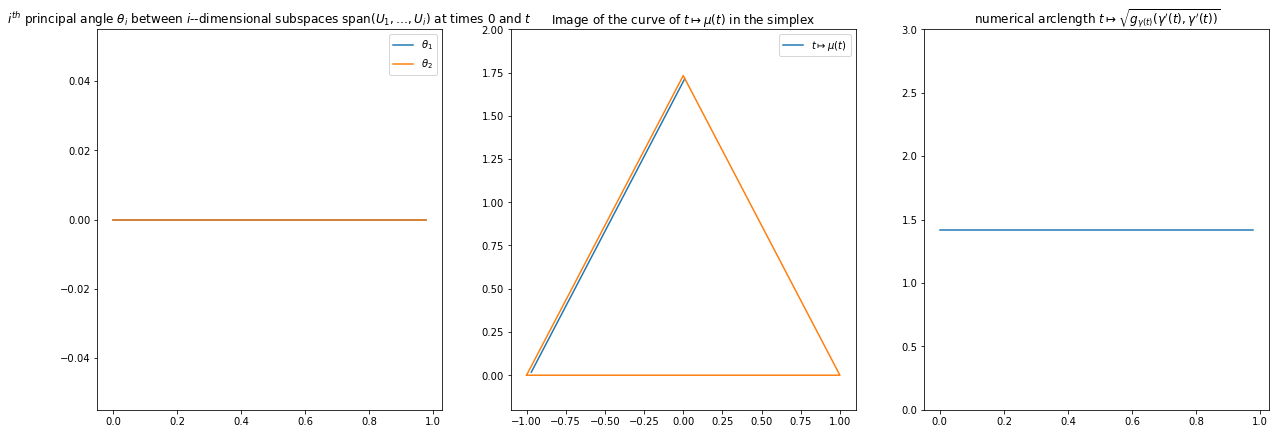

<IPython.core.display.Javascript object>


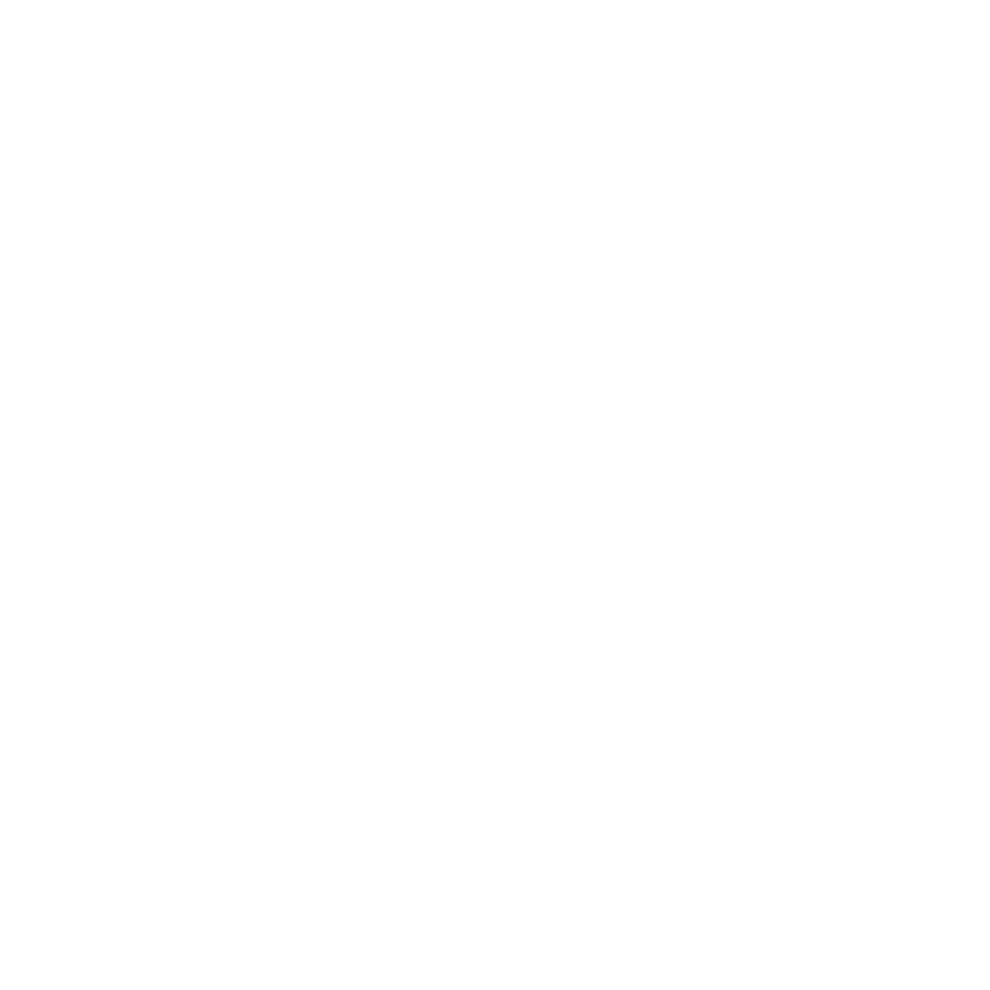

In [10]:
##Example 4: line to R^3
X = np.array([-1,  0, 0., 0., 0.]); nu0 = np.array([0.98, 0.01, 0.01]); U0 = np.eye(3)
tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
traceGeod(tps,nu,U, lambdas, nuprime, l, False,'LineToR3')

In [11]:

##Example 5: plane to R^3
#X = np.array([0.,  -1., 0., 0., 0.]); nu0 = np.array([0.01, 0.98, 0.01]); U0 = np.eye(3)
#tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
#traceGeod(tps,nu,U, lambdas, nuprime, l, False,'PlaneToR3')


##Example 6: plane to plane
#X = np.array([-0.02,  0.04, 0., 0.75, 0.]); nu0 = np.array([0.01, 0.98, 0.01]); U0 = np.eye(3)
#tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
#traceGeod(tps,nu,U, lambdas, nuprime, l, False,'PlaneToPlane')


##Example 7: line to line
#X = np.array([0.04,  -0.02, 0., 0.75, 0.]); nu0 = np.array([0.98, 0.01, 0.01]); U0 = np.eye(3)
#tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
#traceGeod(tps,nu,U, lambdas, nuprime, l, False,'LineToLine')


##Example 8 : plane-line to plane
#X = np.array([-0.5,  0.5, 0., 0.75, 0.]); nu0 = np.array([0.499, 0.499, 0.002]); U0 = np.eye(3)
#tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(X, nu0, U0)
#traceGeod(tps,nu,U, lambdas, nuprime, l, False,'PLaneLineToPlane')


We compare the numerical geodesic obtained in Example 1 with the euclidean geodesic joining the same endpoints.

nu0 = [0.98 0.01 0.01]
nu1 = [0.028 0.95  0.023]
U0 = [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
U1 = [[-0.039  0.738 -0.674]
 [ 0.997  0.072  0.021]
 [ 0.064 -0.671 -0.739]]
itMax = 941
temps max = 0.9400000000000001


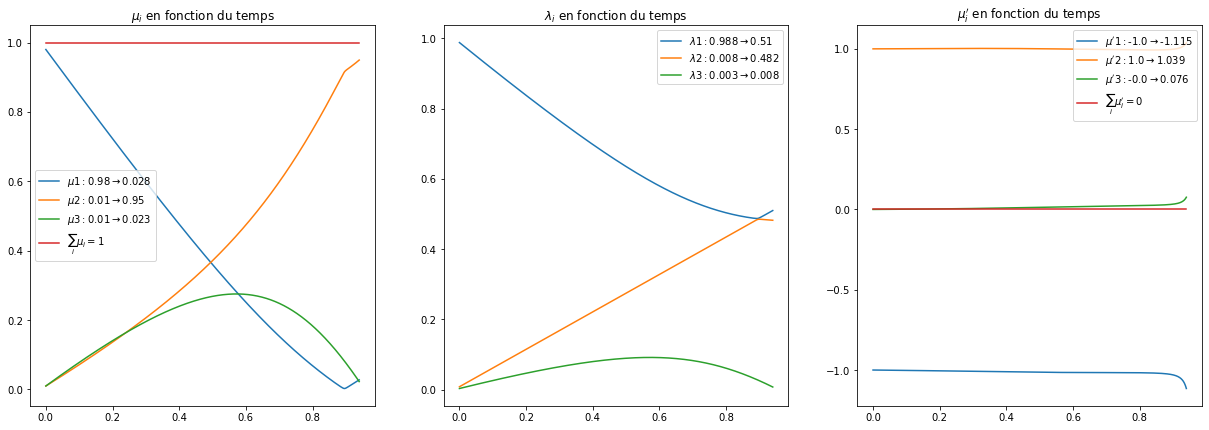

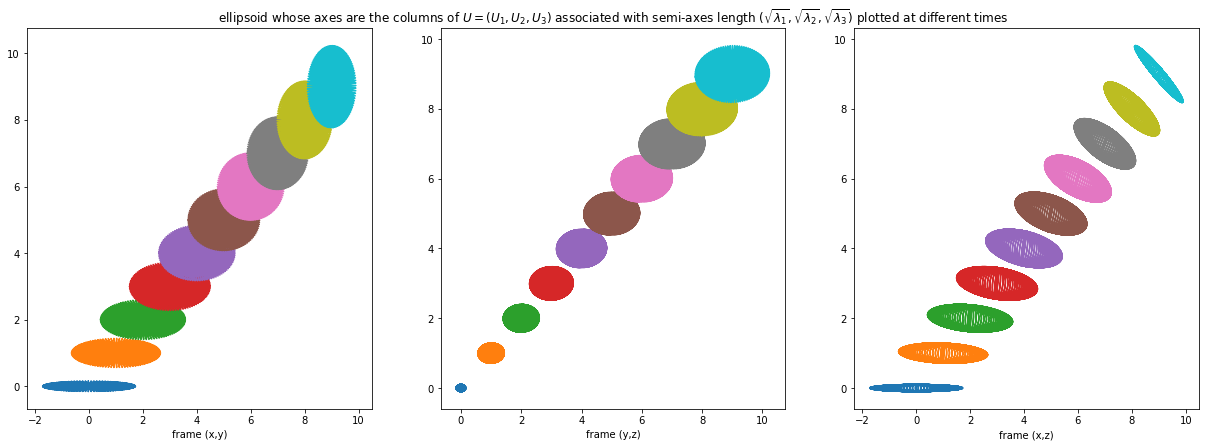

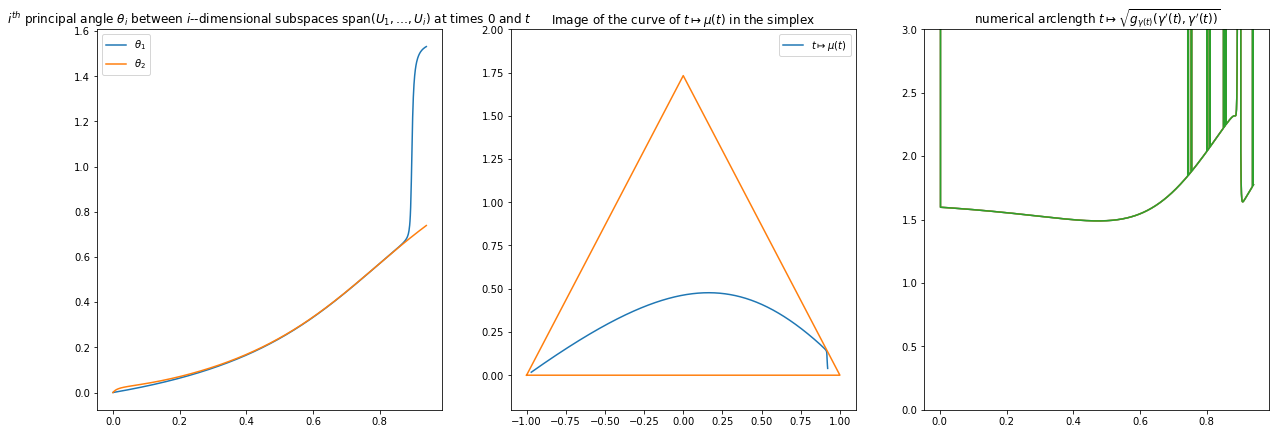

<IPython.core.display.Javascript object>


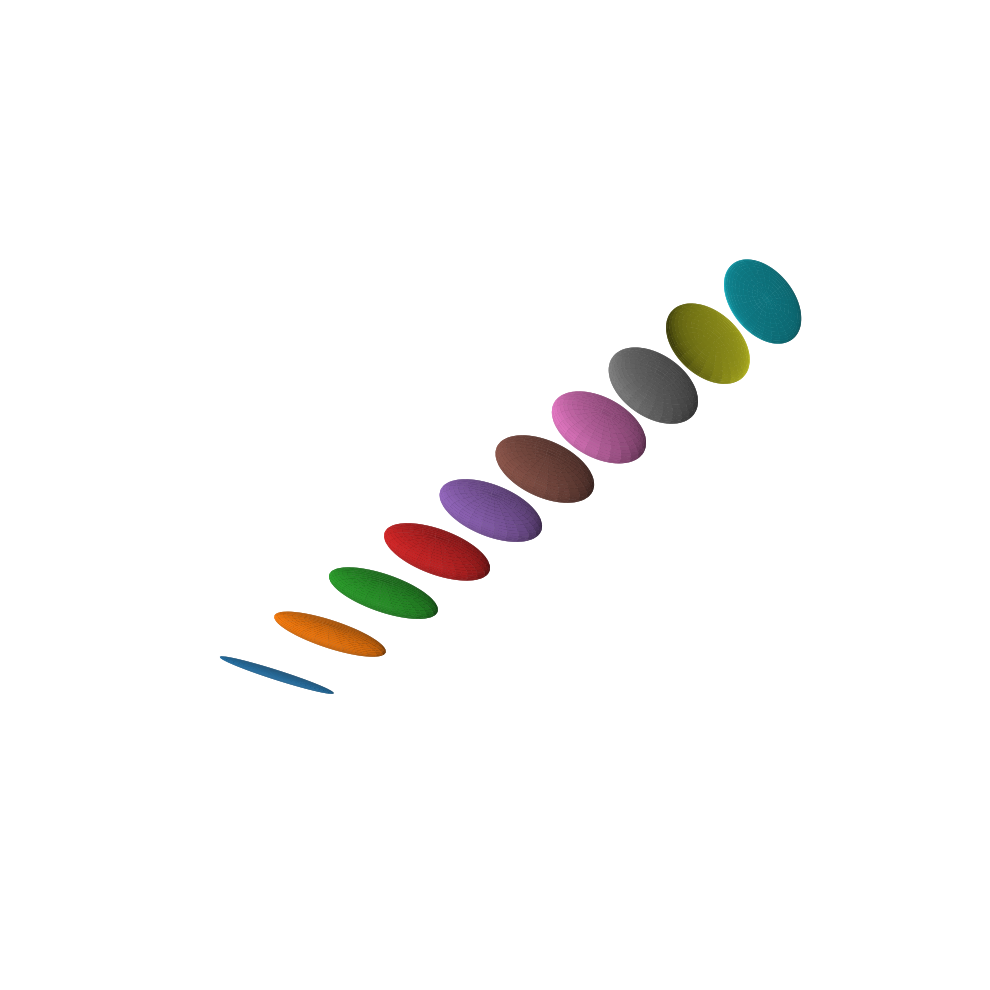

In [12]:
def lamToNu(lbd):
    n = lbd.size
    mu = np.zeros(n)
    for k in range(n-1):
        mu[k] = (k+1)*(lbd[k] - lbd[k+1])
    mu[-1] = n*lbd[-1]
    return mu

def euclGeod(tps,nu0,nu1,U0,U1):
    n = nu0.size
    M0 = U0 @ np.diag(lam(nu0)) @ np.transpose(U0)
    M1 = U1 @ np.diag(lam(nu1)) @ np.transpose(U1)
    N = tps.size
    U = np.zeros((N,n,n))
    t = 0
    lambdas = np.zeros((N,n))
    nu = np.zeros((N,n))
    nuprime = np.zeros((N-1,n))
    length = np.zeros((N,n))
    for i in range(N):
        t = tps[i]/tps[-1]
        #M = (1-t)*M0 + t*M1
        lambdas[i], U[i] = np.linalg.eigh((1-t)*M0 + t*M1)
        lambdas[i] = np.flip(lambdas[i])
        U[i] = np.flip(U[i], axis = 1)
        nu[i] = lamToNu(lambdas[i])
        if i>0:
            nuprime[i-1] = (nu[i] - nu[i-1])/(tps[i]-tps[i-1])
            G = gamma(nu[i])
            B = np.transpose(U[i]) @ (U[i]-U[i-1])/(tps[i]-tps[i-1])
            length[i] = np.sqrt(np.linalg.norm(nuprime[i-1])**2 + np.sum(G**2*B**2))

    return tps, nu, U, lambdas, length


tps, nu, U, lambdas, nuprime, l, e, h = geodStartnD(np.array([-1,  1, 0.05, 0.5, 0.]), np.array([0.98, 0.01, 0.01]),U0)
tps, nu, U, lambdas, l = euclGeod(tps, nu[0], nu[-1], U[0], U[-1])

traceGeod(tps,nu,U, lambdas, nuprime, l, False,'LineToPlaneEucl')
        
 
        